### Importing Libraries

In [1]:
import torch, os, cv2, numpy as np, seaborn as sns
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import ResNet18_Weights
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, auc, roc_curve
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

### Dataset Path

In [ ]:
dataset_path = '/content/drive/MyDrive/BCD_Dataset_Original/'

### Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # rearrange (C, H, W)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # transforms.Normalize(mean, std) : output = (input - mean) / std
])

### Visualizing Preprocessed Images

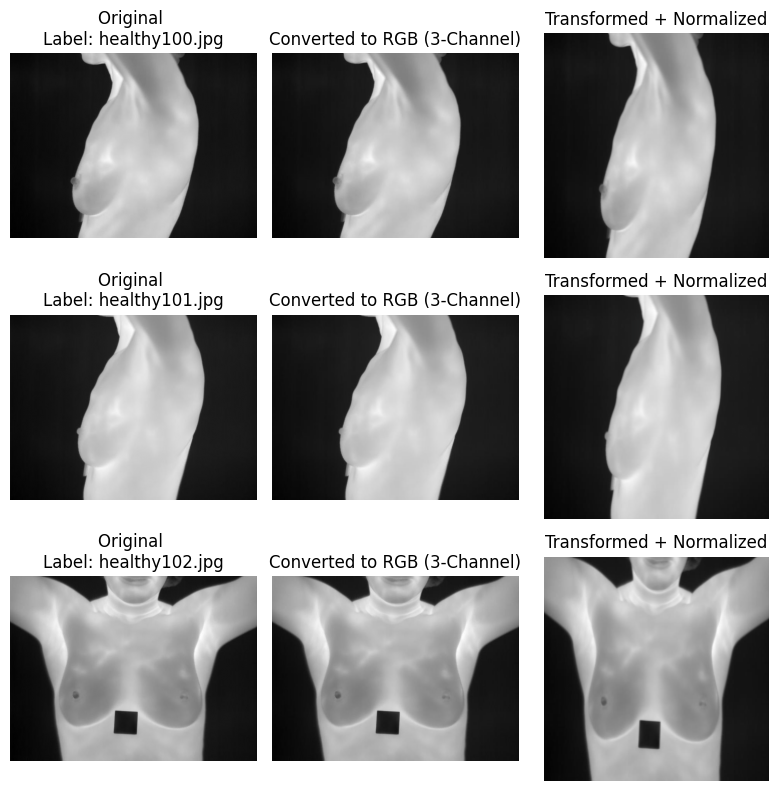

In [ ]:
raw_dataset = datasets.ImageFolder(root=dataset_path)

sample_indices = [0, 1, 2]

plt.figure(figsize=(8, 8))

for i, idx in enumerate(sample_indices):
    image_path, label = raw_dataset.samples[idx][0], raw_dataset.samples[idx][0].split("/")[-1]
    original = Image.open(image_path).convert("L")
    converted = original.convert("RGB")
    transformed_tensor = transform(converted)

    unnorm = transformed_tensor.clone()
    unnorm = unnorm * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    unnorm = unnorm + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    unnorm = unnorm.clamp(0, 1)
    img_np = np.transpose(unnorm.numpy(), (1, 2, 0))

    plt.subplot(len(sample_indices), 3, i*3 + 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"Original \nLabel: {label}")
    plt.axis('off')

    plt.subplot(len(sample_indices), 3, i*3 + 2)
    plt.imshow(converted)
    plt.title("Converted to RGB (3-Channel)")
    plt.axis('off')

    plt.subplot(len(sample_indices), 3, i*3 + 3)
    plt.imshow(img_np)
    plt.title("Transformed + Normalized")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Train-Test-Val Split

In [ ]:
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
batch_size = 16

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

### CPU/GPU Check

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Defining Model

In [ ]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Dropout(p=0.01),
    nn.Linear(model.fc.in_features, 2)  # 2 - binary classification: Healthy vs Sick
)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


### Loss Function & Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-3)

criterion, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 5e-05
     maximize: False
     weight_decay: 0.001
 ))

### Early Stopping Threshold & Epochs

In [ ]:
best_val_loss = float('inf')
patience = 3
patience_counter = 0
num_epochs = 20

In [ ]:
train_loader

### Model Fine-Tuning (Training)

In [ ]:
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

val_precision_history = []
val_recall_history = []
val_specificity_history = []
val_f1_history = []
val_auc_history = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc="Training", leave=False)

    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

        train_pbar.set_postfix({
            "Loss": f"{running_loss / (len(train_pbar) + 1):.4f}",
            "Acc": f"{100 * correct_train / total_train:.2f}%"
        })

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    all_preds = []
    all_labels = []
    all_probs = []  # For AUC (if binary)

    val_pbar = tqdm(val_loader, desc="Validating", leave=False)

    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if outputs.shape[1] == 2:
                probs = torch.softmax(outputs, dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())

            val_pbar.set_postfix({
                "Loss": f"{val_loss / (len(val_pbar) + 1):.4f}",
                "Acc": f"{100 * correct_val / total_val:.2f}%"
            })

    val_loss /= len(val_loader)
    val_acc = 100 * correct_val / total_val
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)

    # Extra Metrics
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    if len(set(all_labels)) == 2:
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        auc = roc_auc_score(all_labels, all_probs)
    else:
        specificity = np.nan
        auc = np.nan

    val_precision_history.append(precision)
    val_recall_history.append(recall)
    val_specificity_history.append(specificity)
    val_f1_history.append(f1)
    val_auc_history.append(auc)

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Precision: {precision:.4f} | Recall(Sens): {recall:.4f} | Specificity: {specificity:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model, "best_model.pth")
        # torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/20



Train Loss: 0.2252 | Train Acc: 91.89% | Val Loss: 0.1660 | Val Acc: 97.97%
Precision: 0.9790 | Recall(Sens): 0.9802 | Specificity: 0.9753 | F1: 0.9796 | AUC: 0.9993
Saved best model!

Epoch 2/20



Train Loss: 0.0480 | Train Acc: 98.99% | Val Loss: 0.0296 | Val Acc: 99.32%
Precision: 0.9926 | Recall(Sens): 0.9938 | Specificity: 0.9877 | F1: 0.9932 | AUC: 0.9998
Saved best model!

Epoch 3/20



Train Loss: 0.0183 | Train Acc: 100.00% | Val Loss: 0.0248 | Val Acc: 99.32%
Precision: 0.9939 | Recall(Sens): 0.9925 | Specificity: 1.0000 | F1: 0.9932 | AUC: 0.9998
Saved best model!

Epoch 4/20



Train Loss: 0.0044 | Train Acc: 100.00% | Val Loss: 0.0147 | Val Acc: 99.32%
Precision: 0.9926 | Recall(Sens): 0.9938 | Specificity: 0.9877 | F1: 0.9932 | AUC: 1.0000
Saved best model!

Epoch 5/20



Train Loss: 0.0022 | Train Acc: 100.00% | Val Loss: 0.0134 | Val Acc: 99.32%
Precision: 0.9926 | Recall(Sens): 0.9938 | Specificity: 0.9877 | F1: 0.9932 | AUC: 1.0000
Saved best model!

Epoch 6/20



Train Loss: 0.0068 | Train Acc: 99.83% | Val Loss: 0.0289 | Val Acc: 98.65%
Precision: 0.9864 | Recall(Sens): 0.9864 | Specificity: 0.9877 | F1: 0.9864 | AUC: 0.9994

Epoch 7/20



Train Loss: 0.0035 | Train Acc: 100.00% | Val Loss: 0.0226 | Val Acc: 99.32%
Precision: 0.9926 | Recall(Sens): 0.9938 | Specificity: 0.9877 | F1: 0.9932 | AUC: 0.9993

Epoch 8/20



Train Loss: 0.0031 | Train Acc: 100.00% | Val Loss: 0.0265 | Val Acc: 98.65%
Precision: 0.9864 | Recall(Sens): 0.9864 | Specificity: 0.9877 | F1: 0.9864 | AUC: 0.9993
Early stopping triggered.


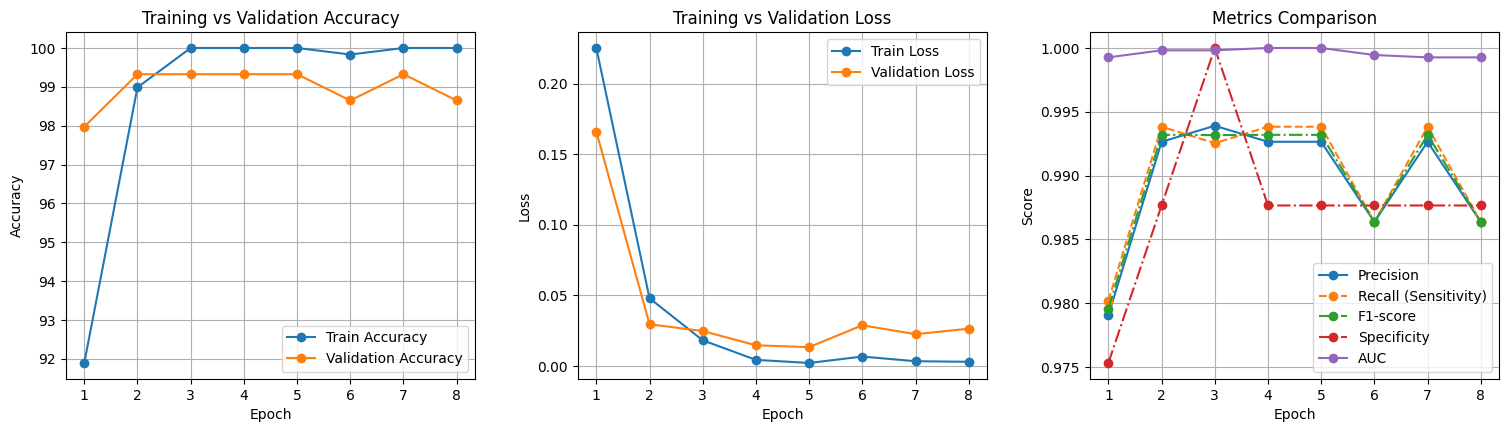

In [ ]:
epochs = list(range(1, len(train_acc_history) + 1))

fig, axes = plt.subplots(1, 3, figsize=(18.5, 4.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.28})

axes[0].plot(epochs, train_acc_history, label='Train Accuracy', marker='o')
axes[0].plot(epochs, val_acc_history, label='Validation Accuracy', marker='o')
axes[0].set_title('Training vs Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs, train_loss_history, label='Train Loss', marker='o')
axes[1].plot(epochs, val_loss_history, label='Validation Loss', marker='o')
axes[1].set_title('Training vs Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(epochs, val_precision_history, label='Precision', marker='o', linestyle='-')
axes[2].plot(epochs, val_recall_history, label='Recall (Sensitivity)', marker='o', linestyle='--')
axes[2].plot(epochs, val_f1_history, label='F1-score', marker='o', linestyle='-.')
axes[2].plot(epochs, val_specificity_history, label='Specificity', marker='o', linestyle='dashdot')
if not all(np.isnan(val_auc_history)):
    axes[2].plot(epochs, val_auc_history, label='AUC', marker='o', linestyle='-')

axes[2].set_title('Metrics Comparison')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Score')
axes[2].legend()
# axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[2].grid(True)

plt.show()

In [2]:
def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


def plot_roc_curve(model, dataloader, device):
    model.eval()
    y_true, y_scores = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)[:, 1]
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend()
    plt.show()

In [8]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_dir = "/content/drive/MyDrive/Unseen_BCD"

test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = test_dataset.classes
class_names

['healthy', 'sick']

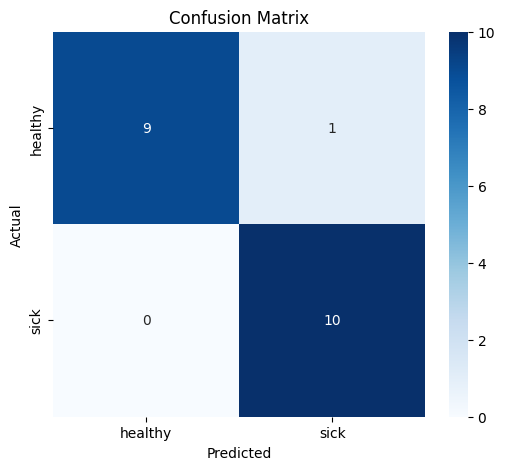

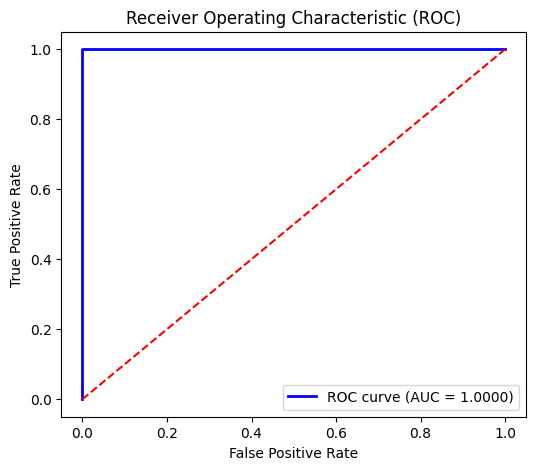

In [9]:
plot_confusion_matrix(model, test_loader, class_names, device)
plot_roc_curve(model, test_loader, device)

In [ ]:
# torch.save(model, "/content/drive/MyDrive/ResNet_SavedModels/breast_cancer_resnet18_[Epoch8_Valloss_0.0074_Trainloss_0.0034].pth")

### Model Validation Check

### Loading Saved Model

In [5]:
# torch.serialization.add_safe_globals([models.ResNet])

# model_path = "/content/drive/MyDrive/ResNet_SavedModels/NF2_breast_cancer_resnet18_[Epoch5_Valloss_0.0134_Trainloss_0.0022].pth"
# model = torch.load(model_path, weights_only=False)
# model.eval()



model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 2)
)

model_path = "/content/drive/MyDrive/ResNet_SavedModels/NF2_breast_cancer_resnet18_[Epoch5_Valloss_0.0134_Trainloss_0.0022].pth"
state_dict = torch.load(model_path, map_location="cpu")

model.load_state_dict(state_dict)


model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

(Sick, 99.98472929000854)



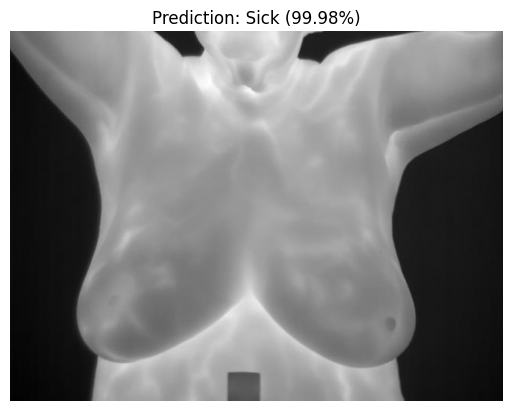

In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("L")
    image_rgb = image.convert("RGB")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    tensor = transform(image_rgb).unsqueeze(0).to(device)
    return image, image_rgb, tensor

def predict(image_path):

    orig_img, orig_img_rgb, img_tensor = preprocess_image(image_path)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)

    classes = ['Healthy', 'Sick']
    label = classes[predicted.item()]
    score = confidence.item() * 100

    print(f"({label}, {score})\n")

    plt.title(f"Prediction: {label} ({score:.2f}%)")
    plt.imshow(orig_img, cmap='gray')
    plt.axis('off')
    plt.show()

predict("/content/drive/MyDrive/Unseen_BCD_Dataset/sick38.jpg")